In [9]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import math
from sklearn.metrics import hamming_loss,confusion_matrix

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset,precomputed_kernel_GridSearchCV
from quantum_kernel.code.visualization_utils import aggregate_folder
from sklearn.svm import SVC

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 18}

rc('font', **font)

tqdm.pandas()

In [2]:
# Get kernel results for the different ml models and dataset.d
dfs = {}
dataset_name='plasticc'
folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/"+dataset_name,'Sparse_IQPm'),
    ("/mnt/c/Users/lslat/Data/QK_project/results/rbf/"+dataset_name, "rbf"),
    ("/mnt/c/Users/lslat/Data/QK_project/results/laplacian/"+dataset_name, 'laplacian'),
]

for folder, kernel_name in folders:
    if dataset_name in dfs:
        temp = aggregate_folder(folder, dataset_name, kernel_name=kernel_name)[
            dataset_name]
        dfs[dataset_name] = pd.concat([dfs[dataset_name], temp])
    else:
        dfs[dataset_name] = aggregate_folder(
            folder, dataset_name, kernel_name=kernel_name)[dataset_name]

save_folder='/mnt/c/Users/lslat/Data/QK_project/figs/'


For /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/plasticc, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/plasticc/aggregated.p
For /mnt/c/Users/lslat/Data/QK_project/results/rbf/plasticc, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/rbf/plasticc/aggregated.p
For /mnt/c/Users/lslat/Data/QK_project/results/laplacian/plasticc, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/laplacian/plasticc/aggregated.p


In [3]:
df = dfs[dataset_name]
rbf_df = df[(df['kernel_name'] == 'rbf') & (df['dataset_dim'] == 18)]
laplacian_df = df[(df['kernel_name'] == 'laplacian') & (df['dataset_dim'] == 18)]
sparse_iqpm_df = df[(df['kernel_name'] == 'Sparse_IQPm') & (df['dataset_dim'] == 18)]
iqp_df = sparse_iqpm_df[(sparse_iqpm_df['log_int_scaling_factor'] == 0.0) & (sparse_iqpm_df['density']==17)]

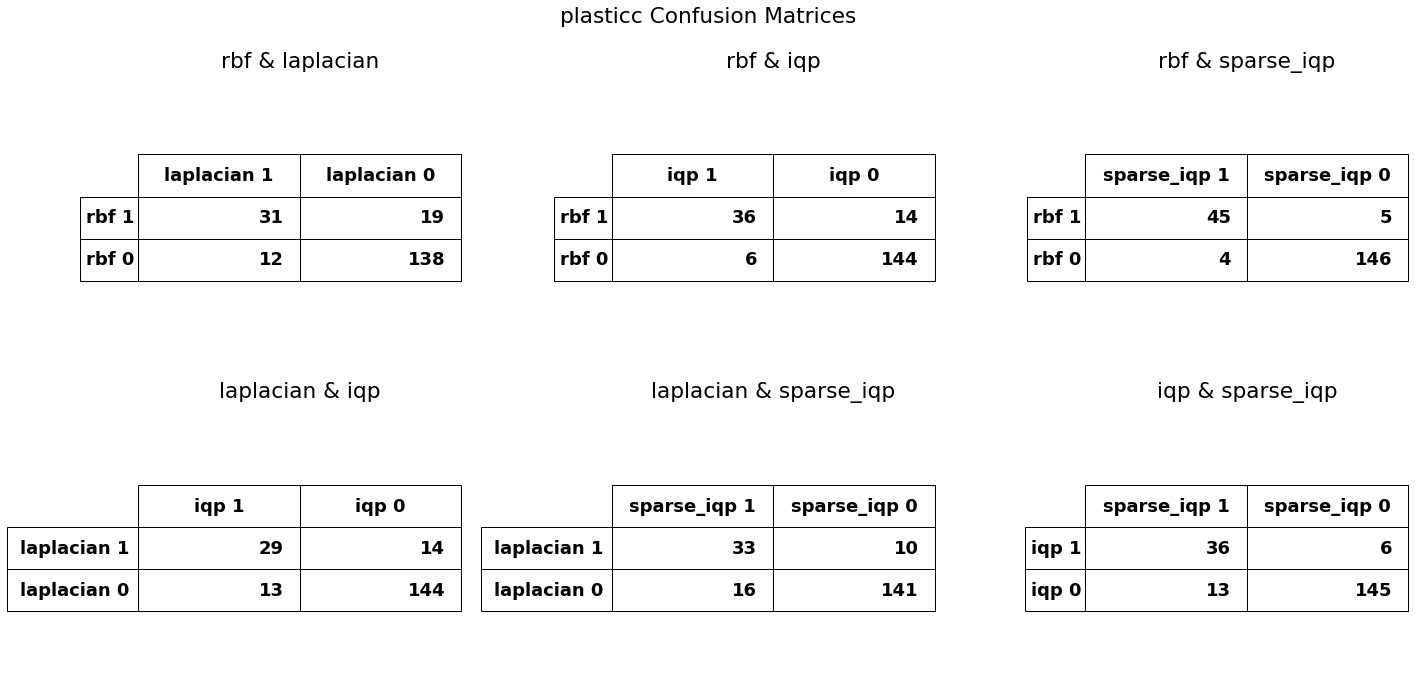

In [52]:
x_train, x_test, y_train, y_test = get_dataset(dataset_name, 18, 800, 200)

predictions={}
for i,(kernel_name,df) in enumerate([('rbf',rbf_df),('laplacian',laplacian_df),('iqp',iqp_df),('sparse_iqp',sparse_iqpm_df)]):
    best_idx = np.argmax(df['test_score'])
    K=df.iloc[best_idx]['qkern_matrix_train']
    K=(K+K.T)/2

    Cs=[0.006, 0.015, 0.03, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256, 512, 1024]
    best_C=precomputed_kernel_GridSearchCV(K, y_train, Cs)

    svc = SVC(kernel='precomputed',C=best_C)
    svc.fit(K, y_train)

    K=df.iloc[best_idx]['qkern_matrix_test']
    predict = svc.predict(K)
    predictions[kernel_name] = predict

kernel_names=['rbf','laplacian','iqp','sparse_iqp']
combos=list(itertools.combinations(kernel_names,r=2))
fig,axs=plt.subplots(2,math.ceil(len(combos)//2),figsize=(20,10))
axs=axs.flatten()
for i,(name1,name2) in enumerate(combos):
    row_names=[name1+' 1',name1+' 0']
    column_name=[name2+' 1',name2+' 0']
    axs[i].axis('off')
    table=axs[i].table(confusion_matrix(predictions[name1],predictions[name2]),rowLabels=row_names,colLabels=column_name,cColors=,rcolors=,fontsize=20,loc='center')
    table.scale(1,3)
    axs[i].set_title(f'{name1} & {name2}')
fig.suptitle(f'{dataset_name} Confusion Matrices',ha='center')
fig.tight_layout()
#fig.savefig(f'{save_folder}{dataset_name}_kernel_eigenvalue_distributions.pdf')